In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re
import statsmodels.api as sm

#Fonction pour trouver les codes correspondants à un pays entre les codes de pays et le nom des pays :"
def refresh_dico ():
    dic = {}
    for i in df1[['Country Name','Country Code']].dropna().drop_duplicates().iterrows() :
        dic[i[1]['Country Name']] = i[1]['Country Code']
    return (dic)
    

#fonction pour trouver toutes les lignes qui correspondent à un pays où à une variable en particulier

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def graph_regress(regresseur,regresse) :
    sns.lmplot(x=regresse, y=regresseur, data=df1.drop(['Country Name','Country Code','Indicator Name'], axis = 1).loc[[regresse,regresseur]].dropna(axis = 1).T, robust = True)

def regress (regresseur,regresse) :
    x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc[regresseur].to_numpy())
    y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc[regresse].to_numpy()

    model = sm.OLS(y,x,'drop')
    results = model.fit()
    return(results)
#/!\ il faut entre le nom avec des caractères regex pour les ( et %)
        

On construit un dictionnaire nom du pays / code du pays :

# On va télécharger les bases de données et repérer les variables pertinentes dans chacune des bases

### On commmence par créer les dataframe

Il faut légèrement modifier le fichier csv dézippé pour enlever les deux premières lignes, qui ne comprennent que des infos générales sur le format du fichier mais qui entrainaient un problème d'ouverture via la commande pd.read_csv car elles comportaient des virgules.

On peut ensuite ouvrir sereinement toutes les base modifiées ainsi.

In [2]:
agri_forest = pd.read_csv("chiffre_agri_foret_peche.csv")
augment_pib = pd.read_csv("chiffre_augment_pib.csv")
energie_utilisee = pd.read_csv("chiffre_energie_utilise.csv")
emission_GES = pd.read_csv("chiffre_GES_total.csv")
nucle_total = pd.read_csv('chiffre_nucle_total_nuke_total_fossile.csv')
part_indus_construc = pd.read_csv('chiffre_part_indus_construc.csv')
pib = pd.read_csv("chiffre_pib.csv")
pop = pd.read_csv('chiffre_population.csv')
nom_pays = pib['Country Name']


In [4]:
df_list  = [agri_forest, augment_pib, energie_utilisee, emission_GES, nucle_total, part_indus_construc, pib, pop]

### On regarde chaque dataframe pour identifier les variables pertinentes

In [5]:
agri_forest.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On observe que tous les df sont construits de la même manière. On a le nom du pays, son abréviation, le nom de l'indicateur utilisé, son code, puis sa valeur pour chaque année. On a aussi toujours une colonne vide, qui ne nous gène pas vraiment.

### On nettoie les bases en enlevant les informations qui ne nous intéresse pas

Il faudra enlever la colomne "unnamed", les colomnes qui correpondent aux années qui ne nous intéresssent pas, et éventuellement les lignes (=pays ou région) que l'on ne garde pas.

Par exemple, conserve-t-on les pays comme Aruba dont on ne connait que le PIB? Je pense que la question elle est vite répondue.

Pareil, est-ce que ça a vraiement un intérêt de garder les zones géographiques du type Asie du Sud-Est, etc?  ce ne sont que des aggrégats de pays, donc pas forcément.

### On fusionne les dataframe pour aggréger tous ces indicateurs

On peut envisager plusieurs manières de fusionner ces df. Soit on a en index Pays_Année et les colomnes correspindent chacune à un indice, soit on a Pays_Indicateur et les colonnes correspondent chacune a une année. Ce sont les formats wide et long (cf tp2).

Pour des raisons de lisibilité, il est évident que l'on va conserver le nom de l'indicateur, et non pas son nom de code. En revanche, il faudra voir à l'usage si on préfère utiler le nom complet des pays ou seulement leur nom de code

On concatène les df, on les trie et on met en index la variable créée à cet effet ci-dessus.

In [9]:
#On fait ici la modif sur tous les df à l'aide d'une boucle for, 
for df in df_list :
    df['Pays_indic'] = df['Country Code'].str[:3] + '_' + df['Indicator Name'].str[:99]
#part_indus_construc['Pays_indic']

df = pd.concat(df_list)
df = df.sort_values('Pays_indic').set_index('Pays_indic')


code_list = []
for i in df['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

for i in code_list :
    df.loc[i+'_PIB par Tete'] = df.loc[i+'_GDP (current US$)'][4:].astype(np.float64)/df.loc[i+'_Population, total'][4:].astype(np.float64)
    df.loc[i+'_Emission de GES par Tete']=df.loc[i+'_Émissions totales de GES (kt d’équivalent CO2)'][4:].astype(np.float64)/df.loc[i+'_Population, total'][4:].astype(np.float64)

### Suppression des colonnes et lignes inutiles

On a ici la liste des colonnes que l'on supprimme pour se restreindre aux données qui nous intéressent, sutrement dit à partir de 1980 (je ne sais plsu si on avait dit 1980 ou 1985).

In [10]:
useless_data_list = ['Unnamed: 65', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 
                   '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '2020']
df = df.drop(useless_data_list, axis = 1)
#df.sample(15)

On va chercher à enlever les lignes qui ne contiennent que peu d'infos (au moins 10 valeurs manquantes)

In [11]:
df1 = df
nan_dict = {}
for i in range(len(df1.index)) :
    nb_nan = df1.iloc[i].isnull().sum()
    if nb_nan >10 :
        nan_dict[list(df.index)[i]] = nb_nan


df1 = df1.drop(index = nan_dict.keys(), axis = 0)
df1.shape

(1916, 43)

En faisant cela, on supprme environ 600 lignes. Pour le rafiner, il faudrait voir si l'on ne doit pas supprimer toutes les données d'un pays lorsque l'on a que des infos sur deux ou trois indicateurs (notamment qi que sur le PIB). On doit pouvoir s'en sortir en supprimant tous les indexs qui commencent par le code du pays détecté de cette manière.

[Adrien]La fonction pour récupérer les indexs des pays où on a moins de 3 indicateurs.

In [12]:
dic_pays = refresh_dico()

In [13]:
for i in dic_pays.keys() :
    if len(rech_ligne_pays(i,df1))<3 :
        df1 = df1.drop(rech_ligne_pays(i,df1))
dic_pays = refresh_dico()
#ancienne fonction que j'ai écrite plus tot (beaucoup plus lente) :

#for i in nom_pays : 
#    compter_nb_indic = df1.apply(lambda x: True if x['Country Name'] == i else False, axis = 1)
#    if len(compter_nb_indic[compter_nb_indic == True].index) <3 :
#        liste_pays_dic[i] = compter_nb_indic[compter_nb_indic == True].index'''


On supprime les lignes des pays dont on a trop peu d'indicateurs complet : (servait pourl'ancienne fonction)

In [14]:
#for i in liste_pays_dic.keys():
#    df1 = df1.drop(index = liste_pays_dic[i], axis = 1)

On a supprimer en tout 58 lignes. De plus on va aussi supprimer de la base les aggrégats de pays (ces lignes là sont colinéaires aux autres, ce qui risque de nous poser problème plus tard dans la prédiction). Voilà les régions à supprimer : Upper middle income, Latin America & the Caribbean (IDA & IBRD countries),Middle East & North Africa (IDA & IBRD countries),South Asia (IDA & IBRD), Middle East & North Africa (IDA & IBRD countries), Latin America & the Caribbean (IDA & IBRD countries),East Asia & Pacific (IDA & IBRD countries), Europe & Central Asia (IDA & IBRD countries), Sub-Saharan Africa, Sub-Saharan Africa (excluding high income), Post-demographic dividend, Pre-demographic dividend, OECD members, North America, Middle East & North Africa (excluding high income), Middle East & North Africa,Late-demographic dividend, Lower middle income
Low & middle income,Latin America & Caribbean,Least developed countries: UN classification, Latin America & Caribbean (excluding high income),IBRD only,IDA & IBRD total,IDA total,IDA blend,Heavily indebted poor countries (HIPC),High income, European Union, Fragile and conflict affected situations,East Asia & Pacific (excluding high income)
Early-demographic dividend, East Asia & Pacific, Europe & Central Asia (excluding high income), Europe & Central Asia,Central Europe and the Baltics


à propos des aggrégats (comment ils aggrègent :)

Aggregation Rules

Aggregates are based on the World Bank’s regional and income classification of economies. Because of missing data, aggregates for groups of economies should be treated as approximations of unknown totals or average values. Regional and income group aggregates are based on the largest available set of data. The aggregation rules are intended to yield estimates for a consistent set of economies from one period to the next and for all indicators. Small differences between sums of subgroup aggregates and overall totals and averages may occur because of the approximations used. In addition, compilation errors and data reporting practices may cause discrepancies in theoretically identical aggregates such as world exports and world imports.

Five methods of aggregation are used in the World Development Indicators:

For group and world totals denoted in the tables by a t, missing data are imputed based on the relationship of the sum of available data to the total in the year of the previous estimate. The imputation process works forward and backward from 2010. Missing values in 2010 are imputed using one of several proxy variables for which complete data are available in that year. The imputed value is calculated so that it (or its proxy) bears the same relationship to the total of available data. Imputed values are usually not calculated if missing data account for more than a third of the total in the benchmark year. The variables used as proxies are GNI in U.S. dollars, total population, exports and imports of goods and services in U.S. dollars, and value added in agriculture, industry, manufacturing, and services in U.S. dollars.

Aggregates marked by an s are sums of available data. Missing values are not imputed. Sums are not computed if more than a third of the observations in the series or a proxy for the series are missing in a given year.

Aggregates of ratios are generally calculated as weighted averages of the ratios (indicated by w) using the value of the denominator or, in some cases, another indicator as a weight. The aggregate ratios are based on available data, including data for economies not shown in the main tables. Missing values are assumed to have the same average value as the available data. No aggregate is calculated if missing data account for more than a third of the value of weights in the benchmark year. In a few cases the aggregate ratio may be computed as the ratio of group totals after imputing values for missing data according to the above rules for computing totals.

Aggregate growth rates are generally calculated as a weighted average of growth rates (and indicated by a w). In a few cases growth rates may be computed from time series of group totals. Growth rates are not calculated if more than half the observations in a period are missing. For further discussion of methods of computing growth rates see below.

Aggregates denoted by an m are medians of the values shown in the table. No value is shown if more than half the observations for countries with a population of more than 1 million are missing. Exceptions to the rules occur throughout the book. Depending on the judgment of World Bank analysts, the aggregates may be based on as little as 50 percent of the available data.
In other cases, where missing or excluded values are judged to be small or irrelevant, aggregates are based only on the data shown in the tables.

Du coup en fonction de comment ils ont agrégés les données ça peut être intéressant ou non de les conserver. Notamment ceux pour lesquels ils ont utilisés la 1ère méthode puisqu'elle nous permet d'avoir une approximation des données qui nous manque (après est ce qu'on veut garder des approximations ? Dans tous les cas il faudra voir je pense si nos prédictions sont robustes à leur ajout ou non)

In [15]:
#/!\ il ne faut faire tourner qu'une seule fois cette fonction, sinon on a une KeyError
liste_supression = ["Upper middle income", "Latin America & the Caribbean (IDA & IBRD countries)","Middle East & North Africa (IDA & IBRD countries)","South Asia (IDA & IBRD)","Middle East & North Africa (IDA & IBRD countries)", "Latin America & the Caribbean (IDA & IBRD countries)","East Asia & Pacific (IDA & IBRD countries)","Europe & Central Asia (IDA & IBRD countries)","Sub-Saharan Africa", "Sub-Saharan Africa (excluding high income)","Post-demographic dividend", "Pre-demographic dividend", "OECD members", "North America", "Middle East & North Africa (excluding high income)", "Middle East & North Africa","Late-demographic dividend", "Lower middle income","Low & middle income","Latin America & Caribbean","Least developed countries: UN classification", "Latin America & Caribbean (excluding high income)","IBRD only","IDA & IBRD total","IDA total","IDA blend","Heavily indebted poor countries (HIPC)","High income","European Union", "Fragile and conflict affected situations","East Asia & Pacific (excluding high income)","Early-demographic dividend","East Asia & Pacific","Europe & Central Asia (excluding high income)","Europe & Central Asia","Central Europe and the Baltics"]

for i in liste_supression :
    df1 = df1.drop(labels = rech_ligne_pays(i,df1)) 
dic_pays = refresh_dico()


On a supprimer en tout une centaine de lignes encore. On actualise la liste pour stocker uniquement les noms des pays restants :

# Premières représentations graphiques

On créé un vecteur temps pour pouvoir créer des graphiques en fonction du temps facilement.

In [16]:
t = np.linspace(1980,2019,40)

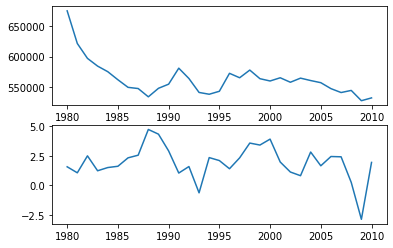

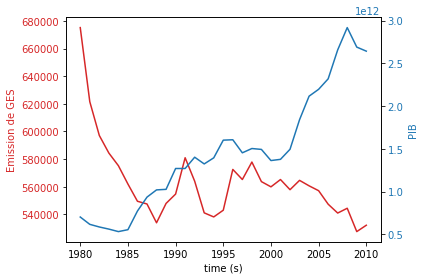

In [17]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

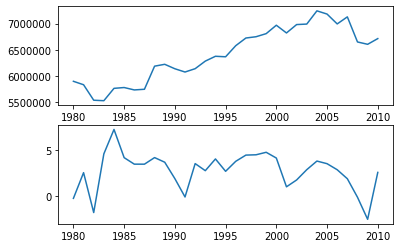

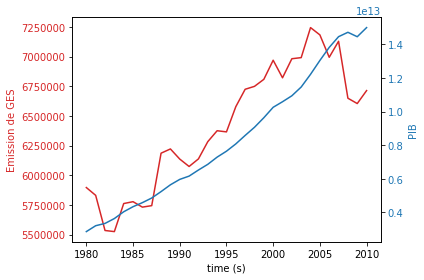

In [18]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


On va créer un nouvel indicateur qui va nous donner la croissance à l'année des gazs à effet de serre pour chaque pays :

In [19]:
for i in rech_ligne_indic('Émissions totales de GES \(kt d’équivalent CO2\)',df1) :
    df1.loc[i[0:3]+'_croissance émissions GES (kt d’équivalent CO2)'] = df1.loc[i][3:44].astype(np.float64).diff()
    df1.loc[i[0:3]+'_croissance émissions GES (pourcent)'] = df1.loc[i[0:3]+'_croissance émissions GES (kt d’équivalent CO2)']*100 /(df1.loc[i[0:3]+'_Émissions totales de GES (kt d’équivalent CO2)']-df1.loc[i[0:3]+'_croissance émissions GES (kt d’équivalent CO2)'] ) 

In [20]:
rech_ligne_indic('Émissions totales de GES \(kt d’équivalent CO2\)',df1)

['AFG_Émissions totales de GES (kt d’équivalent CO2)',
 'AGO_Émissions totales de GES (kt d’équivalent CO2)',
 'ALB_Émissions totales de GES (kt d’équivalent CO2)',
 'ARB_Émissions totales de GES (kt d’équivalent CO2)',
 'ARE_Émissions totales de GES (kt d’équivalent CO2)',
 'ARG_Émissions totales de GES (kt d’équivalent CO2)',
 'ARM_Émissions totales de GES (kt d’équivalent CO2)',
 'ASM_Émissions totales de GES (kt d’équivalent CO2)',
 'ATG_Émissions totales de GES (kt d’équivalent CO2)',
 'AUS_Émissions totales de GES (kt d’équivalent CO2)',
 'AUT_Émissions totales de GES (kt d’équivalent CO2)',
 'AZE_Émissions totales de GES (kt d’équivalent CO2)',
 'BDI_Émissions totales de GES (kt d’équivalent CO2)',
 'BEL_Émissions totales de GES (kt d’équivalent CO2)',
 'BEN_Émissions totales de GES (kt d’équivalent CO2)',
 'BFA_Émissions totales de GES (kt d’équivalent CO2)',
 'BGD_Émissions totales de GES (kt d’équivalent CO2)',
 'BGR_Émissions totales de GES (kt d’équivalent CO2)',
 'BHS_Émis

Maintenant qu'on à la croissance des émissions de gazs à effet de serre par an, on peut représenter la croissance du PIB et celle-ci sur le même graphe :

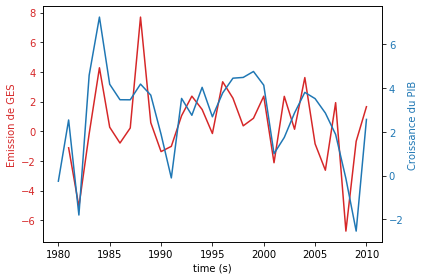

In [21]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_croissance émissions GES (pourcent)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On peut voir qu'il y a apparemment une certaine concommitance des courbes, cela-dit il faut faire attention aux effets d'échelles car ici le PIB ne passe presque jamais dans le négatif (ce qui est loin d'être le cas de la croissance des émissions de gaz à effet de serre). On va essayer de le faire dans le cas de la France pour se faire plus d'idées :

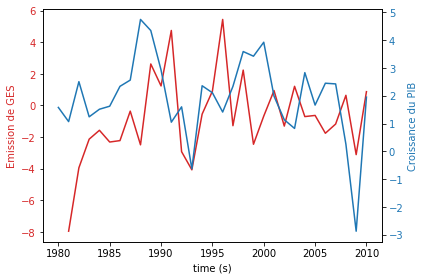

In [22]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_croissance émissions GES (pourcent)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Idée : on pourrait essayer de faire du clustering afin de déterminer la dépendance de la croissance à certains facteurs afin d'essayer de prédire la dépendance de la croissance à l'émission de gaz à effet de serre.

Je vais essayer de régresser le PIB sur l'émission de gaz à effet de serre dans plusieurs pays : la France, Les Etats Unis, La Chine et le Zimbabwe

## Régressions

### Régressions avec scipy

In [42]:
import scipy.optimize
def affin(x,a,b): 
    return a*x + b

def regress2 (country_code, regresse, regresseur, courbe = False):
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)
        if interm.shape != (2,0): 

            regresse_val = pd.DataFrame(interm.loc[country_code + regresse][3:30])[country_code + regresse].to_numpy(dtype = float)
            regresseur_val = pd.DataFrame(interm.loc[country_code + regresseur][3:30])[country_code + regresseur].to_numpy(dtype = float)

            popt, pcov = scipy.optimize.curve_fit(affin, regresseur_val, regresse_val)
            coeff, cst = popt[0], popt[1]

            if courbe == True :
                fig, ax1 = plt.subplots()

                color = 'tab:red'
                ax1.set_xlabel('time (s)' + country_code, color = 'k')
                ax1.set_ylabel(regresse, color='k')
                ax1.plot(t[0:31], df1.loc[country_code + regresse][2:42].to_numpy()[1:32].T, color='k')
                ax1.tick_params(axis='y', labelcolor='k')

                ax1.plot(t[0:31], coeff*df1.loc[country_code + regresseur][2:42].to_numpy()[1:32].T + cst, color='b')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                plt.show()

            return coeff, cst
    else : return 
    
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

regresseur = '_GDP (current US$)'
regresse = '_Émissions totales de GES (kt d’équivalent CO2)'
dic = {}

for code in code_list:
    dic[code] = regress2(code, regresse, regresseur, False)
    if dic[code] == None:
        dic.pop(code)
#Attention, il faudra donner un nom explicit à chaque df, différent pour chaque régression.
regress2_df = pd.DataFrame(dic.values(), dic.keys(), ['Coeff', 'Cst'])
regress2_df.head()

,Coeff,Cst
AGO,-6.620092e-08,41266.421464
ALB,4.616427e-08,7910.371044
ARB,9.907592e-07,657614.053686
ARE,4.617759e-07,57509.188888
ARG,3.505091e-07,232757.502216


### Régressions graphiques avec Seaborn

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics

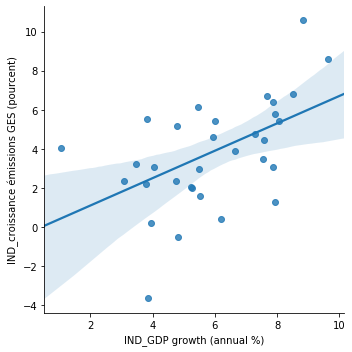

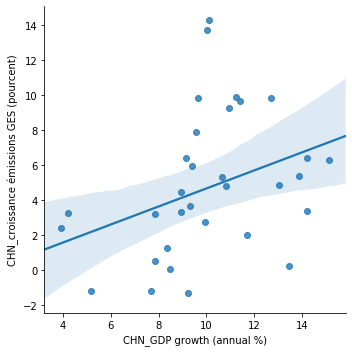

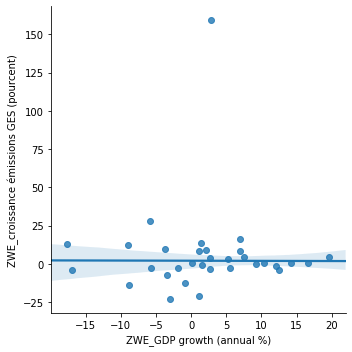

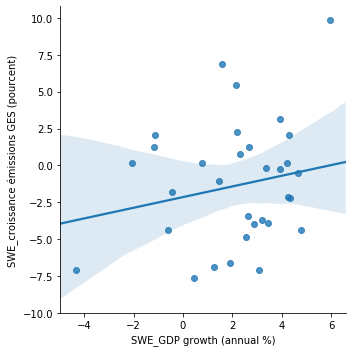

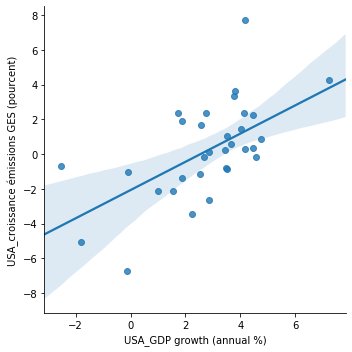

In [26]:

for i in ['IND','CHN','ZWE','SWE','USA']:
    sns.lmplot(x=i+"_GDP growth (annual %)", y=i+"_croissance émissions GES (pourcent)", 
               data=df1.drop(['Country Name','Country Code','Indicator Name'], axis = 1).loc[[i+'_GDP growth (annual %)',i+'_croissance émissions GES (pourcent)']].dropna(axis = 1).T, robust = True)
    
def graph_regress(regresseur,regresse) :
    sns.lmplot(x=regresse, y=regresseur, data=df1.drop(['Country Name',
        'Country Code','Indicator Name'], axis = 1).loc[[regresse,regresseur]].dropna(axis = 1).T, robust = True)

### Régressions avec statsmodels

In [27]:
#On a ici la syntaxe pour faire une régression avec statsmodels, ainsi que la forme de la sortie
x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc['USA_Émissions totales de GES (kt d’équivalent CO2)'].to_numpy())
y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc['USA_GDP (current US$)'].to_numpy()

model = sm.OLS(y,x,'drop')
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     53.28
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           3.25e-08
Time:                        14:16:35   Log-Likelihood:                -988.85
No. Observations:                  33   AIC:                             1982.
Df Residuals:                      31   BIC:                             1985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.343e+13    5.8e+12     -5.762      0.0

In [28]:
#On voit ici coment récupérer les coefficients voulus
print(dir(results))
results._get_robustcov_results
results.rsquared

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_data_attr', '_get_robustcov_results', '_is_nested', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'diagn', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'initialize', 'k_constant', 'llf', 'load', 'model', 'mse_model', 'mse_resid', 'mse_total', 'nobs', 'normalized_cov_params'

0.6321904749624481

On définit ici la fonction qui permet d'automatiser les régressions sur tous les pays, puis on garde les résultats dans un dataframe.

In [29]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            cst = results.params[0]
            coef = results.params[1]

            return cst, coef, r2
    
    else : return

    
    
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

regresse = '_GDP (current US$)'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'

for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)
        
regress_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante', 'Coefficient', 'R2'])
regress_df.head()

,Constante,Coefficient,R2
AGO,41207.191385,-2.577127e-08,0.018065
ALB,8720.110365,-3.120555e-08,0.003241
ARB,822732.568287,6.780234e-07,0.656422
ARE,56172.066313,4.438433e-07,0.917791
ARG,239837.609818,2.982657e-07,0.509120


On peut ensuite effectuer toutes les régressions que l'on souhaite graâce à cette fonction, en changeant simplementles variables regresseur et regresse. Il suffit à chaque fois de créer un dataframe avec un nom différent, de donner des noms plus explicits aux colonnes, et de les concaténer après.

Exemple ci-dessous, en concaténant la régression de gdp sur ges avec celle sur leurs taux de variation

In [48]:
regresse = '_GDP (current US$)'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'


for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)
        
regress1_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante GDP sur total GES',
                                                     'Coefficient GDP sur total GES', 'R2 GDP sur total GES'])
regress1_df.head()




regresse = '_PIB par Tete'
regresseur = '_Emission de GES par Tete'

dic = {}
for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)

regress2_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante GDP_var sur GES_tete', 'Coefficient GDP_var sur GES_tete', 'R2 GDP_var sur GES_var'])

regress_df = pd.concat([regress1_df, regress2_df], axis = 1)
regress_df.head()

C:\Users\Titouan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Constante GDP sur total GES,Coefficient GDP sur total GES,R2 GDP sur total GES,Constante GDP_var sur GES_tete,Coefficient GDP_var sur GES_tete,R2 GDP_var sur GES_var
AGO,41207.191385,-2.577127e-08,0.018065,0.003699,-5.078478e-07,0.310325
ALB,8720.110365,-3.120555e-08,0.003241,0.002747,2.821586e-08,0.002799
ARB,822732.568287,6.780234e-07,0.656422,0.004042,3.928051e-07,0.319756
ARE,56172.066313,4.438433e-07,0.917791,0.046873,-2.950150e-07,0.052396
ARG,239837.609818,2.982657e-07,0.509120,0.008266,6.733994e-08,0.107357


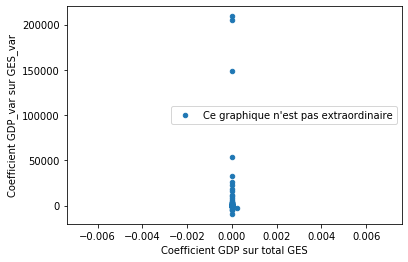

In [32]:
regress_df.plot(x='Coefficient GDP sur total GES', y='Coefficient GDP_var sur GES_var', kind = 'scatter', label = "Ce graphique n'est pas extraordinaire")

### Graphiques sur seaborn

Pour tracer les graphiques, afin de simplifier l'utilisation du module, on va créer un dataframe qui n'est rien d'autre que la transposé du précédent, où l'on a enlevé les trois colonnes qui ne correspondent pas à des données chiffrées.

In [129]:
country_code = 'USA'
var1 = '_GDP (current US$)'
var2 = '_Émissions totales de GES (kt d’équivalent CO2)'
var3 = '_Alternative and nuclear energy (% of total energy use)'

year = list(df1)[3:]
for i in range(len(year)):
    year[i] = float(year[i])

df_plot = df1.drop(['Country Name', 'Country Code', 'Indicator Name'], axis = 1)
df_plot.loc['year'] = year
df_plot = df_plot.T
df_plot.head(15)

Pays_indic,ABW_GDP (current US$),ABW_GDP growth (annual %),"ABW_Population, total","AFG_Population, total",AFG_Émissions totales de GES (kt d’équivalent CO2),AGO_Alternative and nuclear energy (% of total energy use),AGO_Energy use (kg of oil equivalent per capita),AGO_GDP (current US$),AGO_GDP growth (annual %),"AGO_Population, total",...,WLD_croissance émissions GES (pourcent),WSM_croissance émissions GES (kt d’équivalent CO2),WSM_croissance émissions GES (pourcent),YEM_croissance émissions GES (kt d’équivalent CO2),YEM_croissance émissions GES (pourcent),ZMB_croissance émissions GES (kt d’équivalent CO2),ZMB_croissance émissions GES (pourcent),ZWE_croissance émissions GES (kt d’équivalent CO2),ZWE_croissance émissions GES (pourcent),year
1980,NaN,NaN,60096.0,13356511.0,15691.2660,1.121397,547.044587,5.930503e+09,NaN,8341289.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980.0
1981,NaN,NaN,60567.0,13171673.0,15810.3350,1.114046,531.589110,5.550483e+09,-4.400001,8640446.0,...,-3.172873,84.305333,44.413249,104.25780,1.335454,-24252.304000,-13.039750,-922.688,-4.054677,1981.0
1982,NaN,NaN,61345.0,12882528.0,15615.3330,1.197734,506.059344,5.550483e+09,0.000000,8952950.0,...,6.021602,-46.242566,-16.869118,562.36590,7.108497,21619.566000,13.367262,903.570,4.138466,1982.0
1983,NaN,NaN,62201.0,12537730.0,15322.5300,1.067446,501.904917,5.784342e+09,4.200001,9278096.0,...,-1.506701,3.808297,1.671163,526.56240,6.214193,-35.916000,-0.019588,-123.331,-0.542424,1983.0
1984,NaN,NaN,62836.0,12204292.0,14278.7921,1.098590,489.327132,6.131475e+09,6.000002,9614754.0,...,-3.040496,23.853315,10.295300,185.51110,2.061210,-41599.650000,-22.692512,-627.623,-2.775412,1984.0
1985,NaN,NaN,63026.0,11938208.0,13545.7369,1.208085,500.924865,7.553560e+09,3.499999,9961997.0,...,0.784963,8.700717,3.404774,419.73270,4.569455,2430.069000,1.714707,1909.708,8.685992,1985.0
1986,4.054634e+08,NaN,62644.0,11736179.0,12269.4624,1.194329,489.111697,7.072063e+09,2.900002,10320111.0,...,2.928455,-9.948027,-3.764694,404.95260,4.215906,-9191.621000,-6.376461,2111.366,8.835729,1986.0
1987,4.876025e+08,16.078431,61833.0,11604534.0,12400.5073,1.166168,483.624483,8.083872e+09,4.082749,10689250.0,...,5.620393,10.828437,4.258180,92.69940,0.926040,53084.692000,39.334337,2153.126,8.278980,1987.0
1988,5.964236e+08,18.648649,61079.0,11618005.0,12959.2948,1.120664,486.037649,8.769251e+09,6.128890,11068050.0,...,-1.347983,16.575470,6.251928,1541.38080,15.256660,-55818.763000,-29.684148,1209.376,4.294618,1988.0
1989,6.953044e+08,12.129841,61032.0,11868877.0,12348.9570,1.110309,480.094200,1.020110e+10,0.041621,11454777.0,...,1.777609,-3.978760,-1.412404,398.19160,3.419602,16781.397000,12.691684,894.828,3.046779,1989.0


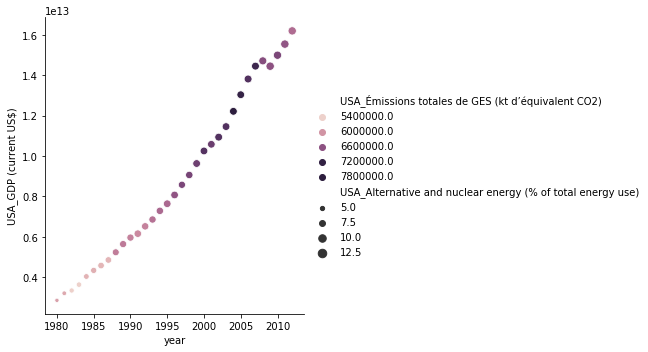

In [130]:
sns.relplot(data = df_plot, x= 'year', y = country_code + var1,
            hue = country_code + var2, size = country_code + var3)